<a href="https://colab.research.google.com/github/thejreese30/cmsc320_finalproject/blob/main/Final_Project_FD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction**

## MLB game outcome predictive analysis, Summer 2024 Data Science Project
**Group Members :** Justin Reese, Carter Grismore

**Topic :** Major League Baseball prediction anaylsis

**About our project :**
We have gathered hitting statistics, pitching statistics, team ablility represented as an elo score and win/loss records of each team. This is an encompassing dataset that will allow us to lock in on factors that affect the outcome of mlb games.


**The elo score of a team is defined as:** *The Elo Rating System is a method for calculating the relative skill levels of players in competitor-versus-competitor games such as chess. The FiveThirtyEight website applied this system to baseball, rating the teams from every season in modern history.*

Specifically, we wish to see if we can use any of these stats to uncover patterns or features of an mlb game that provide insight in the game's outcome and discover if any of these stats have any relation to each other. Our ultimate goal is to use the features of the game provided by this dataset, or a subset of these features, to predict the outcome of an MLB game.

Notably, the task of classifying, or predicting the outcome of an mlb sports game is extremely complex, due to the multitude of factors that randomly affect a game. The inherent, random predicatablility as well as randomness and variance in predicting sports results in even the best models only acheiving 59% accuracy  (1). We employ a neural network in the primary analysis section of this report to try to succeed predecessor models.

1. https://towardsdatascience.com/a-machine-learning-algorithm-for-predicting-outcomes-of-mlb-games-fa17710f3c04





#**Data Curation**

**Dataset Link :** https://www.kaggle.com/datasets/saurabhshahane/major-league-baseball-dataset

**Data Explaination :** This dataset contains detailed information about baseball games, including dates and seasons, whether games were neutral or part of playoffs, and team abbreviations for home and away teams. It also includes various metrics such as Elo ratings and probabilities before and after games, ratings of teams and starting pitchers, and final scores. These metrics provide insights into team performance, the impact of starting pitchers, and the predictive power of Elo and rating systems in determining game outcomes. Overall, the dataset offers a comprehensive view of baseball game dynamics and predictive analytics in sports.

##Importing

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from scipy import stats as stat
og_df = pd.read_csv('mlb_elo.csv')

## Cleaning
Here we are cleaning up our dataset. We dropped the playoff column because it was empty in the dataset. We also dropped all NaN values as we only wanted games with complete data. We then added a Win/Loss column computed as whether team 1 won or loss a win/loss column indicating if the home team or away team won/loss.

Finally, we dropped the all columns related to names (team names, pitcher names) as these are classifications unrelated to the performance of a team. Post game stastics/updates were also dropped as our classification only relies on pregame statistics

In [38]:
# Checking the number of entries before cleaning
print(f"Number of entries before clean (rows): {og_df.shape[0]}")
og_df = og_df.drop(columns=['playoff'])

# Dropping rows with NaN values in any row
og_df = og_df.dropna()
og_df.reset_index(drop=True, inplace=True)

og_df['Win/Loss'] = og_df.apply(lambda row: 1 if row['score1'] > row['score2'] else 0, axis=1)
columns_to_drop = ['pitcher1', 'pitcher2', 'pitcher1_adj', 'pitcher2_adj', "elo1_post", "elo2_post", "rating1_post", "rating2_post", "neutral", "date"]
og_df = og_df.drop(columns=columns_to_drop)
og_df = og_df[og_df['season'] > 2010]
og_df.reset_index(drop=True, inplace=True)
# Checking the number of entries after cleaning

print(f"Number of entries after clean (rows): {og_df.shape[0]}")
print(og_df)



Number of entries before clean (rows): 228326
Number of entries after clean (rows): 29174
       season team1 team2     elo1_pre     elo2_pre  elo_prob1  elo_prob2  \
0        2023   ANA   LAD  1512.215927  1552.053419   0.477224   0.522776   
1        2023   SFG   SDP  1538.547938  1521.911870   0.558215   0.441785   
2        2023   MIL   ARI  1500.260192  1518.303942   0.508571   0.491429   
3        2023   HOU   NYM  1546.336898  1507.673066   0.589215   0.410785   
4        2023   CHW   TEX  1480.355417  1536.750404   0.453514   0.546486   
...       ...   ...   ...          ...          ...        ...        ...   
29169    2011   STL   SDP  1509.702000  1508.499000   0.536207   0.463793   
29170    2011   NYY   DET  1537.933000  1508.583000   0.576179   0.423821   
29171    2011   LAD   SFG  1501.181000  1543.763000   0.473284   0.526716   
29172    2011   KCR   ANA  1470.198000  1512.867000   0.473159   0.526841   
29173    2011   CIN   MIL  1513.882000  1493.243000   0.563890 

# **Data Exploration**
Here we are exploring our dataset to see what we are working with and to understand the relationships between key features such as Elo ratings, team ratings, and scores. The code first calculates and visualizes the differences in Elo, team ratings, and scores using box plots, followed by generating a heatmap to show the correlation between variables. It also performs a t-test to compare Elo and team ratings, identifies and visualizes outliers in score differences, and plots a comparison of scores for two teams across all games, highlighting outliers. Finally a correlation matrix was generated in an attempt to uncover any relationships among the data en mass. This comprehensive analysis helps us identify trends, outliers, and correlations within the dataset.

On an aside, differences in elo and rating between both teams were computed as a measure of the relative ability of one teamm to the other. The score difference was also computed, so we could assess whether there was a correlation with the magnitude in of difference in team ability and the magnitude of the score difference.

**Helpful Links:**

1) https://www.stratascratch.com/blog/basic-types-of-statistical-tests-in-data-science/

2) https://www.jmp.com/en_us/statistics-knowledge-portal/exploratory-data-analysis/types-of-graphs.html#dfe680e8-803d-4e90-9345-45a5bade157b



             season      elo1_pre      elo2_pre     elo_prob1     elo_prob2  \
count  29174.000000  29174.000000  29174.000000  29174.000000  29174.000000   
mean    2016.563790   1505.843424   1505.755581      0.534040      0.465960   
std        3.611734     34.771138     34.692367      0.070088      0.070088   
min     2011.000000   1380.751101   1377.385723      0.271628      0.224888   
25%     2013.000000   1480.764202   1480.691472      0.486366      0.417238   
50%     2016.000000   1506.925500   1506.724326      0.534932      0.465068   
75%     2019.000000   1530.253317   1529.879903      0.582762      0.513634   
max     2023.000000   1628.754251   1626.163610      0.775112      0.728372   

        rating1_pre   rating2_pre  pitcher1_rgs  pitcher2_rgs  rating_prob1  \
count  29174.000000  29174.000000  29174.000000  29174.000000  29174.000000   
mean    1505.827167   1505.759133     50.783294     50.818177      0.533638   
std       37.285668     37.216408      4.359984    

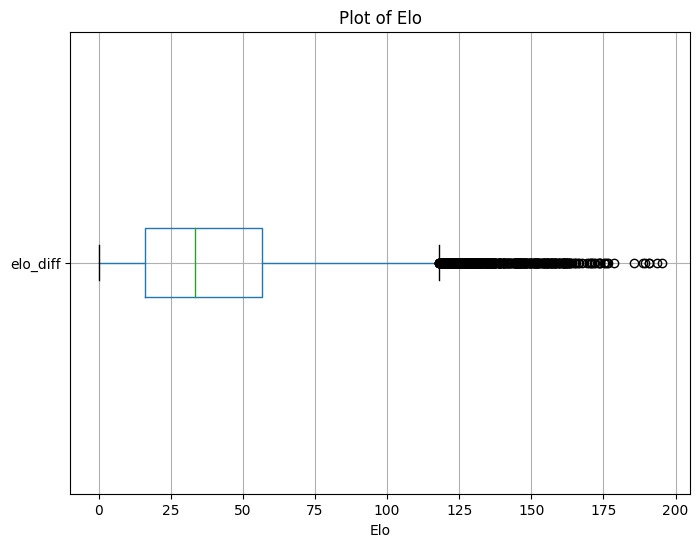

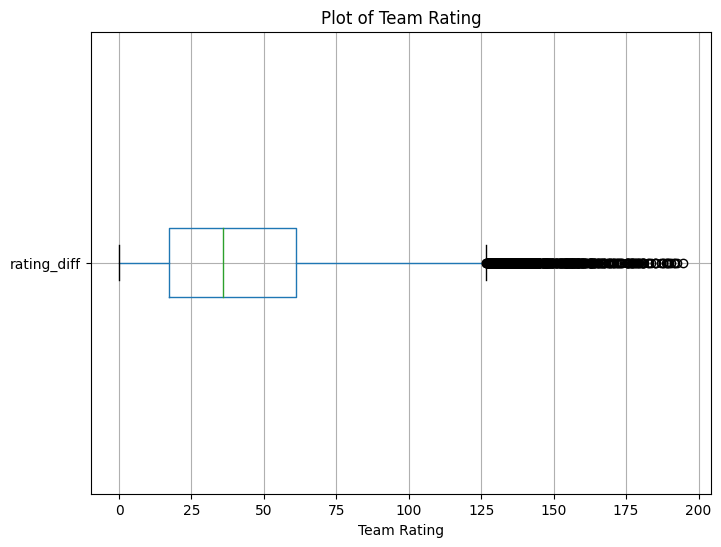

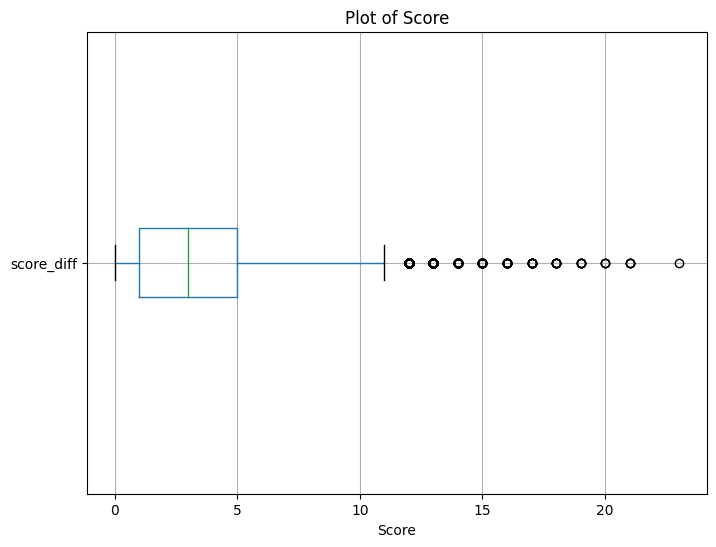

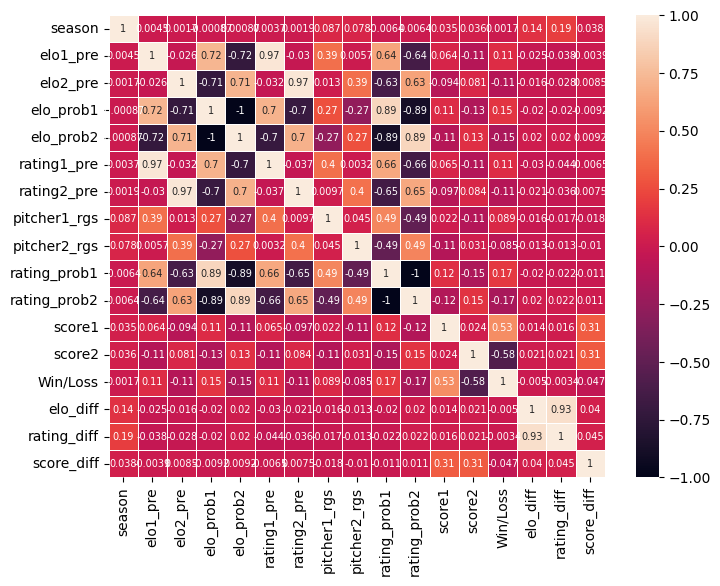







p-val = 0.7504241754176937


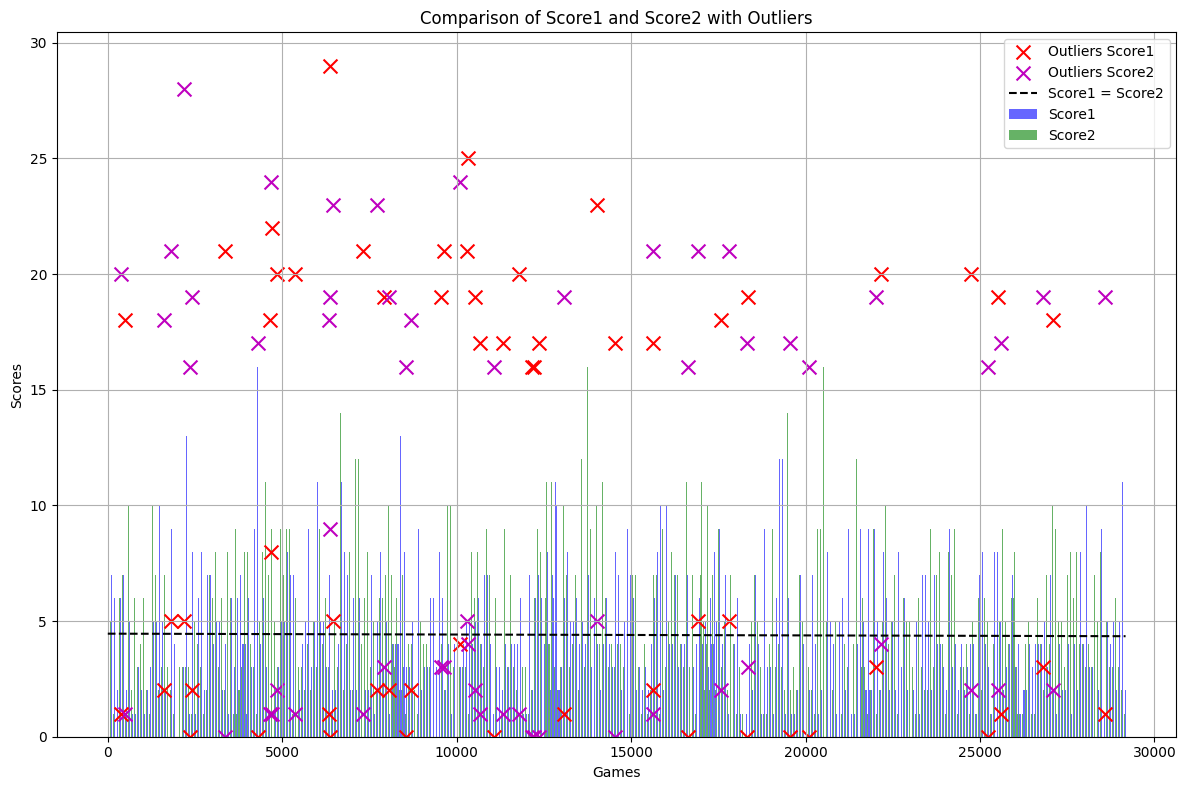

In [39]:
print(og_df.describe())

og_df['elo_diff'] = abs(og_df['elo1_pre'] - og_df['elo2_pre'])
og_df['rating_diff'] = abs(og_df['rating1_pre'] - og_df['rating2_pre'])
og_df['score_diff'] = abs(og_df['score1'] - og_df['score2'])

plt.figure(figsize=(8, 6))
og_df.boxplot(column='elo_diff', vert=False)
plt.title('Plot of Elo')
plt.xlabel('Elo')
plt.show()

plt.figure(figsize=(8, 6))
og_df.boxplot(column='rating_diff', vert=False)
plt.title('Plot of Team Rating')
plt.xlabel('Team Rating')
plt.show()

plt.figure(figsize=(8, 6))
og_df.boxplot(column='score_diff', vert=False)
plt.title('Plot of Score')
plt.xlabel('Score')
plt.show()

# view correlation between variables

tmp = og_df.copy()
tmp = tmp.drop(columns=['team1','team2'])
cm = tmp.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, linewidths=0.5,
            annot_kws={"size": 7})
plt.show()

_, p_val = stat.ttest_rel(og_df['elo1_pre'], og_df['rating1_pre'])
print("\n\n\n\n\n")
print(f"p-val = {p_val}")

# Scores Run at each game, looking for outliers
og_df['score_diff'] = og_df['score1'] - og_df['score2']


outliers = og_df[abs(og_df['score_diff']) > 15]


corr = og_df[['score1', 'score2']].corr().iloc[0, 1]


plt.figure(figsize=(12, 8))

#Plotting data to assess correlations, type of relationship...
bar_width = 0.35
index = og_df.index
plt.bar(index, og_df['score1'], width=bar_width, label='Score1', color='b', alpha=0.6)
plt.bar(index + bar_width, og_df['score2'], width=bar_width, label='Score2', color='g', alpha=0.6)


plt.scatter(outliers.index, outliers['score1'], color='r', label='Outliers Score1', marker='x', s=100)
plt.scatter(outliers.index, outliers['score2'], color='m', label='Outliers Score2', marker='x', s=100)


plt.plot([og_df.index.min(), og_df.index.max() + 1], [og_df['score1'].mean(), og_df['score2'].mean()], color='k', linestyle='--', label='Score1 = Score2')


plt.xlabel('Games')
plt.ylabel('Scores')
plt.title('Comparison of Score1 and Score2 with Outliers')
plt.legend()
plt.grid(True)
plt.tight_layout()


plt.show()



##**Possible Questions to Answer**

**Analysis:**
We utilize the difference between stats for team 1 and team 2 to work with a unified metric. The descriptive statistics for all values found in the dataframe are displayed in the data descriptive statistic table. Notably, the mean difference in elo was 0.09 and the mean difference in ratings was 0.089. These numbers numbers suggest that we can expect two teams to be evenly matched during competition. Moreover, the expected score difference was 0.110 which suggest that most games played will end in a tie, with a slight favor towards team1.

The displayed heatmap reveals that a dismal correlation exists between the elo statistics (elo_pre and elo_prob) for teams 1 and 2 and the outcome of the game
(Win/Loss category) as the correlation coefficient between all these values and the Win/Loss category were below 0.2. Even when considering the difference in ELO
to the score difference, no correlation was found.

**Conclusion:** The elo and rating statistics on there own do not correlate to the outcome of the game. We must utilize more variable to determine if we can accurately predict the outcome of a game.

Also visible from heat map the elo diff and rating diff as well as the elo pre and rating pre had a 0.98 correlation with each, thus it is worth determining if any correlation exist between the elo pregram stat and the rating pregame stat. We proceed with a Z-test (alpha 0.05)

**H0 :** There is no difference between the elo_pre value and the rating_pre value

**HA :** A difference in the elo_pre and the rating_pre value exists

Result of ttest between rating1_pre and elo1_pre. Note that we only conduct this test as the elo prob and rating prob
have 0.98 correlation coefficient as well per the heatmap displayed. Additionally, the correlation was similar for both teams 1 and 2 we allow our alpha significance value to be 0.05 as values under this suggest a > 95% confidence in the alternative hypothesis.

**Conclusion:** The observed p-val = 0.92 suggesting strong evidence for the null hypothesis. We accept the null hypothesis that the elo_pre and the rating_pre are similar statistics and consider this for feature engineering and dimension reduction later

**Conclusion of 'Comparison of Score1 and Score2 with Outliers':** We notice theres a lot of games with the score above 15. This is over about 24000 games since the year 2010. This could be for many different reasons but this mainly tells us that most games, the winner will be scoring below 15 runs when we train our mchaine learning model.



#**Primary Anaylsis**
The correlation matrix displayed in the exploratory data analysis section reveals that a strong relationship does not exist between any of the pregame statistics and the outcome of the game or the magnitude of the score difference. Here, we attempt to see if a combination of features including the elo ability and pitcher ratings can classify the outcome of a game as a win or loss. The team rating statistic is dropped here, as in the previous section it was found to have a 0.98 correlation with the elo rating for that team. We proceed with a multi-layered neural network model to search for complex patterns between the remaining features and accomplish our classification task.

In [40]:
#essential feature set based of data exploration section
features = ['pitcher1_rgs', 'pitcher2_rgs', 'elo1_pre', 'elo2_pre']

# the target that will be used to assess model accuracy
target = 'Win/Loss'
og_df = og_df[features + [target]]

# Encoding the numerical variables (no categorical variables now), standard scaler used so
# no feature has an astronomical effect on computation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features)
    ])

X = og_df[features]
y = og_df[target]


X_preprocessed = preprocessor.fit_transform(X)


# Splitting the data into training and testing sets, random seed of 42 used
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Train andt test tensors being created as input for the Neural Network
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

#Creating Tensor Datasets and DataLoaders to be used during epoch cycles of training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Our Neural network defintion
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 256) # first layer with 256 neurons for complexity
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128) # number of neurons decrease with each layer to save space and time
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64,32)
        self.fc6 = nn.Linear(32,16)
        self.fc7 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid() # logistic regression for binary classification task computed at the end

    def forward(self, x):
        x = torch.relu(self.fc1(x)) # each foward pass we push the input through every layer, applying the relu activation func to all layers except the output
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)
        x = self.sigmoid(x) # after this backpropagation will be computed to update weights
        return x

model = Net()

# Loss function & Optimizer
criterion = nn.BCELoss() #used BCELoss() function as recommended by Professor after exam
optimizer = optim.Adam(model.parameters(), lr=0.001) #used Adam optimizer as done in HW #4

num_epochs = 50 # epochs were kept small to have reasonable computation time

#Training model and arrays to track change in loss, accuracies, precisions and recalls
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []

for epoch in range(num_epochs):

  #Train the model for an epoch
    model.train()
    train_loss = 0.0
    all_train_outputs = []
    all_train_labels = []

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        #get predictions
        outputs = model(X_batch)

        #Calculate loss and backpropagate to update model
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        all_train_outputs.extend(outputs.detach().cpu().numpy())
        all_train_labels.extend(y_batch.cpu().numpy())

    #udpate training changes arrays
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    all_train_outputs = np.array(all_train_outputs)
    all_train_labels = np.array(all_train_labels)
    train_predicted = (all_train_outputs > 0.5).astype(int)
    train_accuracy = accuracy_score(all_train_labels, train_predicted)
    train_precision = precision_score(all_train_labels, train_predicted)
    train_recall = recall_score(all_train_labels, train_predicted)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)


#evaluate model on test data, much of same process as above except we only take final values
model.eval()
with torch.no_grad():
    all_outputs = []
    all_labels = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        all_outputs.extend(outputs.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)
    predicted = (all_outputs > 0.5).astype(int)
    final_accuracy = accuracy_score(all_labels, predicted)
    final_precision = precision_score(all_labels, predicted)
    final_recall = recall_score(all_labels, predicted)

print(f'Final Test Accuracy: {final_accuracy * 100}%')
print(f'Final Test Precision: {final_precision * 100}%')
print(f'Final Test Recall: {final_recall * 100}%')

Final Test Accuracy: 56.486718080548414%
Final Test Precision: 59.08309455587393%
Final Test Recall: 64.9858178380082%


#**Visualization**

We tracked the loss, accuracy, precision and recall over our model during the training process to observe its performance during training. As visible in the graphs below, the stochastic gradient descent process used to train our model results in a decrease in minimized loss as well as increasing precision, recall and accuracy during training. The overall assessment of our model is displayed by the histogram visualizing the number of correct predictions compared to the number of incorrect predictions. Additionally, a confusion matrix displays the overall performance of our model.


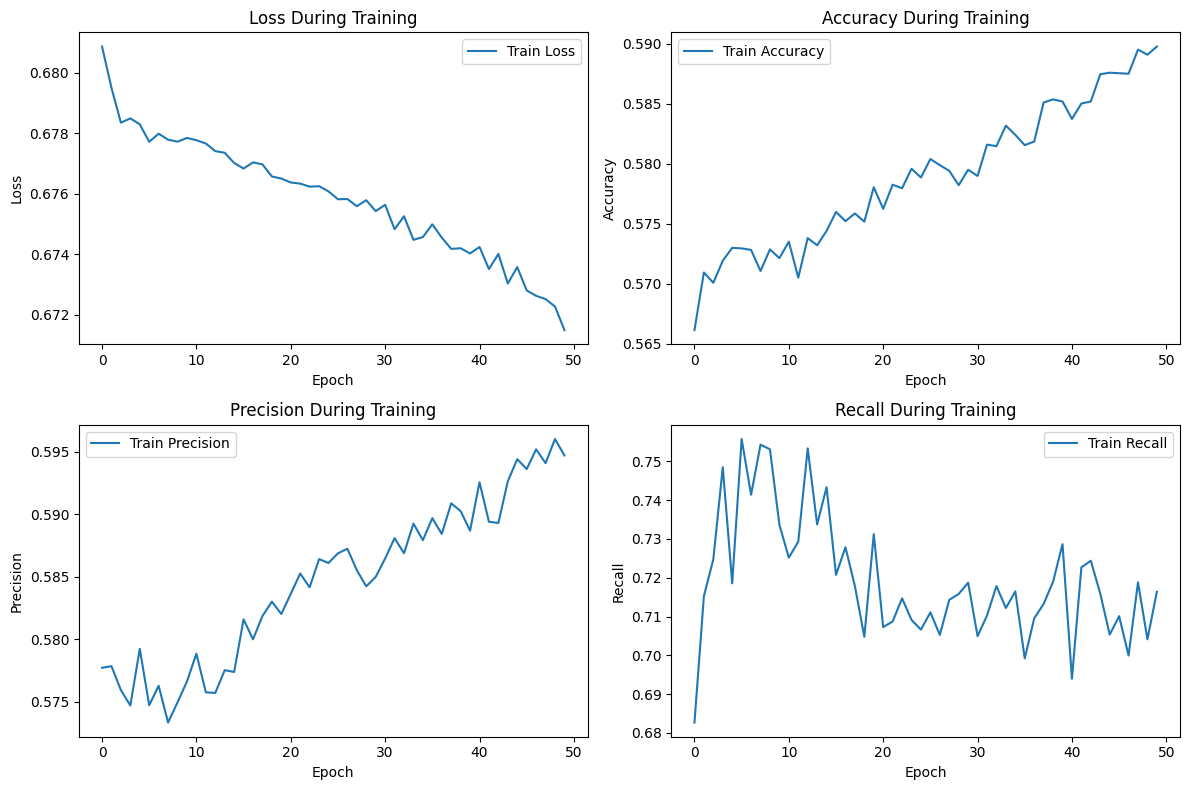

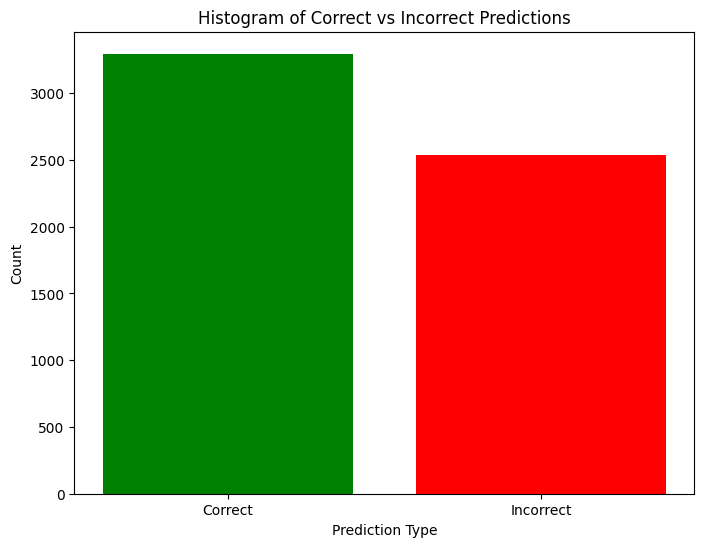

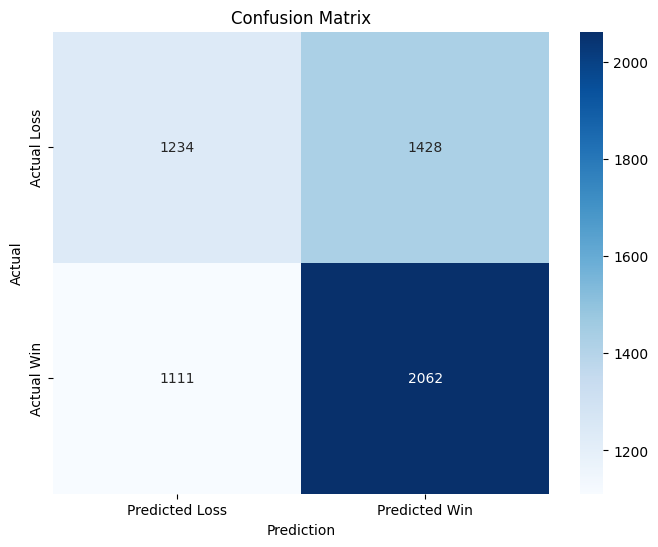

In [41]:
#plot change in loss during training
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')

plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#plot change in accuracy, precision and recall during training
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')

plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_precisions, label='Train Precision')

plt.title('Precision During Training')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_recalls, label='Train Recall')

plt.title('Recall During Training')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

correct_preds = (predicted == all_labels).sum()
incorrect_preds = (predicted != all_labels).sum()

#visualize number of correct to incorrect predictions
plt.figure(figsize=(8, 6))
plt.bar(['Correct', 'Incorrect'], [correct_preds, incorrect_preds], color=['green', 'red'])
plt.title('Histogram of Correct vs Incorrect Predictions')
plt.xlabel('Prediction Type')
plt.ylabel('Count')
plt.show()

#confusion matrix to describe model performance
conf_matrix = confusion_matrix(all_labels, predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Loss', 'Predicted Win'], yticklabels=['Actual Loss', 'Actual Win'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

#**Insights and Conclusions**

**Insights :**
Several features from the dataset pertaining to post game statistics were removed since our goal was to use pregame statistics to predict the outcome of a game. The remaining variables utilized in this predicitive analysis were the two teams and their elo ratings pre game and their starting pitcher ratings. These variables became input features to our predictive model. Notably, a 1 or Win means team 1 won against team 2.

The predictive model employed here was a neural network composed of 7 dense layers each with a relu activation function (for non-linearity), as well as a sigmoid output layer to achieve our binary classification task (W/L). Additionally, The first layer contained 256 neurons, with this number gradually decreasing to 1 to allow for complex analysis, but also save space with forward passses. A neural network was employed here in place of other machine learning models due to the complexity and non-linearity present in the relationships necessary to predict the outcome of a sports game. The large dataset along with the complex data made a neural network the prevailing model to learn and apply these relationships. We utilized the MSE loss function to quantify our error for learning

All categorical data such as "Win/Loss" and team names were encoded with one hot encoding.  

After training and evaluating our model by calculating the number of correct predictions against the total number of predictions, our model had an accuracy as higha as 58%, a fairly significant accuracy considering the random events that affect the outcome of sports games. Moreover, our model dispalyed a precision as high as 59% and a recall as high as 75%. Amidst the inherent unpredicatability of sports games, this suggest when our model says team 1 will win it has a feasible degree of correctness and the overall accuracy is amongst some of the best predicitve models for baseball games.


**Conclusions :
Though our model only marginally out performs a random guess for a binary classification problem, the difference is significant given the randomness in variance in baseball game predictions. Our multi-layered neural network has shown that given only pitcher ratings and pregame elo ratings reflecting a teams ability, a prediction can be made about the outcome of the game that beats random guessing. Further analysis would be required to see if a superset of features could acheive better predictive results.
 **